In [1]:
from pandas_datareader import data as pdr 
from datetime import date
import yfinance as yf 
yf.pdr_override()
import pandas as pd
import matplotlib.pyplot as plt 
import math
import quandl
import numpy as np

/home/juan/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [47]:
ticker_sp = '^GSPC'
ticker_gold = 'GC=F'
ticker_oil = 'CL=F'
ticker_dax = '^GDAXI'
ticker_nikkei = '^N225'
ticker_ftse = '^FTSE'
ticker_shanghai = '000001.SS'

auth_tok = "Nv1rJgRR7u88iz_dg7Y6"

end_date = "2020-05-1"
start_date = "1950-01-01"

In [48]:
def getGOLDData ():
    # Contains price and volume
    data = quandl.get("CHRIS/CME_GC1", trim_start = start_date, trim_end = end_date, authtoken=auth_tok)
    data = data[['Last', 'Volume']]
    data.columns = ["GOLD Adj Close", "GOLD Volume"]
    return data.dropna()

def getSPData():
    # Contains price and volume
    data = pdr.get_data_yahoo(ticker_sp, start=start_date, end=end_date)
    data = data[data.columns[4:6]] 
    data.columns = ["SP500 Adj Close",  "SP500 Volume"]
    return data

def getDAXData():
    # Contains price and volume
    data = pdr.get_data_yahoo(ticker_dax, start=start_date, end=end_date)
    data = data[data.columns[4:6]]
    data.columns = ["DAX Adj Close",  "DAX Volume"]
    return data


def getOILData():
    # Contains price and volume
    data = quandl.get("CHRIS/CME_CL1", trim_start = start_date, trim_end = end_date, authtoken=auth_tok)
    data = data[["Last", "Volume"]]
    data.columns=["OIL Adj Close", "OIL Volume"]
    return data.dropna()


def getNIKKEIData():
    # Contains only price
    data = pdr.get_data_yahoo(ticker_nikkei, start=start_date, end=end_date)
    data = data[data.columns[4:5]] 
    data.columns = ["NIKKEI Adj Close"]
    return data


def getFTSEData():
    # Contains price and volume
    data = pdr.get_data_yahoo(ticker_ftse, start=start_date, end=end_date)
    data = data[data.columns[4:6]] 
    data.columns = ["FTSE Adj Close",  "FTSE Volume"]
    return data

def getSHANGHAIData():
    # Contains only price
    data = pdr.get_data_yahoo(ticker_shanghai, start=start_date, end=end_date)
    data = data[data.columns[4:5]] 
    data.columns = ["SHANGHAI Adj Close"]
    return data

In [49]:
def checkData (data):
    counter = 0
    for index, row in data.iterrows():
        for item in row:
            if (math.isnan(item)):
                counter += 1
                break
    return counter

def normalizeData(data):
    for column in data:
        maxValue = max(data[column])
        data[column] = data[column] / maxValue

In [50]:
def combineData():
    #allData = [getSPData(), getGOLDData(), getDAXData(), getOILData(), getNIKKEIData(), getSHANGHAIData(), getFTSEData()]
    allData = [getSPData()]
    mergedData = pd.concat(allData, axis = 1)
    print("REMOVED: {} DATA POINTS".format(checkData(mergedData)))
    cleanData = mergedData.dropna()
    normalizeData(cleanData)
    return cleanData

In [51]:
data = combineData()

print(data)

day_counter = 0

# Size of prediction
prediction_size = 3

# Number of days in the past
historical_size = 15

# Size of available data.
data_size = len(data) - prediction_size - historical_size

# Size of data alocated to training
training_size = int(0.85*data_size)

# Size of data alocated to testing
testing_size = data_size - training_size

# Number of data elements in a single day
daily_data_size = 2 

x_train = np.zeros((training_size, historical_size, daily_data_size))
y_train = np.zeros((training_size))
x_test  = np.zeros((testing_size, historical_size, daily_data_size))
y_test  = np.zeros((testing_size))

sanity_train = np.zeros((training_size, 3))
sanity_test = np.zeros((testing_size, 3))

[*********************100%***********************]  1 of 1 completed
REMOVED: 0 DATA POINTS
            SP500 Adj Close  SP500 Volume
Date                                     
1950-01-03         0.004920      0.000110
1950-01-04         0.004976      0.000165
1950-01-05         0.005000      0.000223
1950-01-06         0.005015      0.000175
1950-01-09         0.005044      0.000220
...                     ...           ...
2020-04-24         0.837748      0.469132
2020-04-27         0.850075      0.453400
2020-04-28         0.845618      0.495179
2020-04-29         0.868098      0.577864
2020-04-30         0.860101      0.569395

[17696 rows x 2 columns]


In [52]:
day_counter = 0

for index, row in data.iterrows():
    
    if (day_counter == data_size):
        print("100% completed")
        break

    if (day_counter < len(x_train)):
        
        
        for i in range (historical_size):
            for j in range (daily_data_size):
                x_train[day_counter][i][j] = data.iloc[day_counter + i][j]
                
        base_value = data.iloc[day_counter + historical_size - 1]['SP500 Adj Close']
        future_values = []
        for i in range (prediction_size):
            future_values += [data.iloc[day_counter + historical_size + i]['SP500 Adj Close']] 
        average_future = sum(future_values) / len(future_values)
        if ((average_future - base_value) > 0):
            delta = 1
        else:
            delta = 0
            
        y_train[day_counter] = delta
        
        sanity_train[day_counter] = np.array(future_values)
        
        
    else:
        
        for i in range (historical_size):
            for j in range (daily_data_size):
                x_test[day_counter - len(x_train)][i][j] = data.iloc[day_counter + i][j]
                
        base_value = data.iloc[day_counter + historical_size - 1]['SP500 Adj Close']
        future_values = []
        for i in range (prediction_size):
            future_values += [data.iloc[day_counter + historical_size + i]['SP500 Adj Close']] 
        average_future = sum(future_values) / len(future_values)
        if ((average_future - base_value) > 0):
            delta = 1
        else:
            delta = 0
            
        y_test[day_counter - len(y_train)] = delta
        
        sanity_test[day_counter - len(y_train)] = np.array(future_values)
        
    day_counter += 1
    print("{}% completed".format(int(100 * day_counter/data_size)), end = '\r')

100% completed


In [53]:
y_train = y_train.astype('uint8')
y_test  = y_test.astype('uint8') 

In [54]:
# Balance out training data
ones = 0
zeros = 0
for i in y_train:
    if (i == 1):
        ones += 1
    else:
        zeros += 1
balanced_x_train = np.zeros((2*min(ones,zeros), historical_size, daily_data_size))
balanced_y_train = np.zeros((2*min(ones,zeros)))
balanced_sanity_train = np.zeros((2*min(ones,zeros), 3))

# Insert ones
index = 0
for i in range (len(x_train)):
    if (y_train[i] == 1):
        balanced_x_train[index] = x_train[i]
        balanced_y_train[index] = y_train[i]
        balanced_sanity_train[index] = sanity_train[i]
        index += 1
        
    if (index == min(ones, zeros)):
        break
        
# Insert zeros
for i in range (len(x_train)):
    if (y_train[i] == 0):
        balanced_x_train[index] = x_train[i]
        balanced_y_train[index] = y_train[i]
        balanced_sanity_train[index] = sanity_train[i]
        index += 1
        
    if (index == len(balanced_x_train)):
        break

In [55]:
# Balance out testing data
ones = 0
zeros = 0
for i in y_test:
    if (i == 1):
        ones += 1
    else:
        zeros += 1
balanced_x_test = np.zeros((2*min(ones,zeros), historical_size, daily_data_size))
balanced_y_test = np.zeros((2*min(ones,zeros)))
balanced_sanity_test = np.zeros((2*min(ones,zeros), 3))

# Insert ones
index = 0
for i in range (len(x_test)):
    if (y_test[i] == 1):
        balanced_x_test[index] = x_test[i]
        balanced_y_test[index] = y_test[i]
        balanced_sanity_test[index] = sanity_test[i]
        index += 1
        
    if (index == min(ones, zeros)):
        break
        
# Insert zeros
for i in range (len(x_test)):
    if (y_test[i] == 0):
        balanced_x_test[index] = x_test[i]
        balanced_y_test[index] = y_test[i]
        balanced_sanity_test[index] = sanity_test[i]
        index += 1
        
    if (index == len(balanced_x_test)):
        break

In [56]:
ones = 0
zeros = 0
for i in balanced_y_test:
    if (i == 1):
        ones += 1
    else:
        zeros += 1
        
print(ones)
print(zeros)

1114
1114


In [57]:
# Shuffle training data
randomize_training = np.arange(len(balanced_x_train))
np.random.shuffle(randomize_training)
balanced_x_train = balanced_x_train[[randomize_training]]
balanced_y_train = balanced_y_train[[randomize_training]]
balanced_sanity_train = balanced_sanity_train[[randomize_training]]

# Shuffle testing data
randomize_testing = np.arange(len(balanced_x_test))
np.random.shuffle(randomize_testing)
balanced_x_test = balanced_x_test[[randomize_testing]]
balanced_y_test = balanced_y_test[[randomize_testing]]
balanced_sanity_test = balanced_sanity_test[[randomize_testing]]

/home/juan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/home/juan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """
/home/juan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

In [58]:
balanced_y_train = balanced_y_train.astype('uint8')
balanced_y_test  = balanced_y_test.astype('uint8') 

In [59]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

/home/juan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/juan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/juan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/juan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [60]:
# Defining the type of model
model = Sequential()

# Defining the model
model.add(LSTM(256, input_shape = balanced_x_train.shape[1:], activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(256, activation = 'relu', return_sequences = True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [61]:
opt = tf.keras.optimizers.Adam(lr=5e-5, decay = 1e-6)

# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
# Train the model
history = model.fit(balanced_x_train, balanced_y_train, 
                    batch_size = 64, epochs = 300, 
                    validation_data = (balanced_x_test, balanced_y_test))

Train on 13870 samples, validate on 2228 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
13870/13870 [==============================] - 50s 4ms/sample - loss: 0.7433 - acc: 0.5418 - val_loss: 0.6977 - val_acc: 0.5000
Epoch 2/300
13870/13870 [==============================] - 48s 3ms/sample - loss: 0.7003 - acc: 0.5472 - val_loss: 1.0665 - val_acc: 0.5000
Epoch 3/300
13870/13870 [==============================] - 56s 4ms/sample - loss: 0.6833 - acc: 0.5516 - val_loss: 5.0300 - val_acc: 0.5000
Epoch 4/300
13870/13870 [==============================] - 54s 4ms/sample - loss: 0.6748 - acc: 0.5521 - val_loss: 10.5260 - val_acc: 0.4987
Epoch 5/300
13870/13870 [==============================] - 53s 4ms/sample - loss: 0.6716 - acc: 0.5495 - val_loss: 12.9734 - val_acc: 0.5000
Epoch 6/300
13870/13870 [==============================] - 54s 4ms/sample - loss: 0.6654 - acc: 0.5482 - val_loss: 9.5027 - val_acc: 0.4996
Epoch 7/300
138

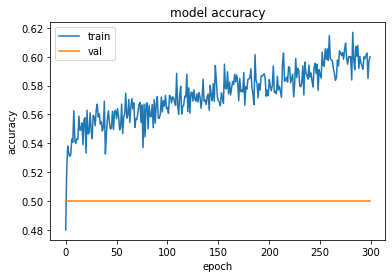

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [100]:
x = np.array([np.array([1,1,1,1]),np.array([2,2,2,2,2]),np.array([3,3,3,3,3])])
x = x[np.array([2,1,0])]
print(x)

[array([3, 3, 3, 3, 3]) array([2, 2, 2, 2, 2]) array([1, 1, 1, 1])]


In [32]:
print(balanced_x_train)

[[[0.40103953 0.33303713 0.85889765 ... 0.37767126 0.71729581 0.18475693]
  [0.40036324 0.32259303 0.85497962 ... 0.37637154 0.72191831 0.20435599]
  [0.39145048 0.35740117 0.82834754 ... 0.3711188  0.71474061 0.17761747]
  ...
  [0.39940936 0.2535616  0.84137237 ... 0.35633513 0.72256032 0.15434532]
  [0.39616379 0.30294434 0.83644835 ... 0.35528852 0.72728558 0.13752033]
  [0.39615788 0.29907657 0.83427755 ... 0.35708514 0.72733693 0.13722603]]

 [[0.35263352 0.14673239 0.22115741 ... 0.17627002 0.63976631 0.39970907]
  [0.35143453 0.15207272 0.22179277 ... 0.17598932 0.63835388 0.37179242]
  [0.35368192 0.14438519 0.22131625 ... 0.17381107 0.64135849 0.44278452]
  ...
  [0.35382662 0.14526419 0.22629322 ... 0.18192312 0.64591678 0.33378509]
  [0.35462693 0.14501717 0.2272992  ... 0.18159564 0.64848484 0.28170109]
  [0.3555395  0.14822939 0.22634616 ... 0.17949011 0.64802257 0.31172717]]

 [[0.43765338 0.07938039 0.14803833 ... 0.32803797 0.83018747 0.16888418]
  [0.43713066 0.084521

In [33]:
print(balanced_x_test)

[[[0.72577711 0.22988889 0.69365172 ... 0.55213319 0.94572417 0.1506767 ]
  [0.72992926 0.29225234 0.70042887 ... 0.5516708  0.9541089  0.17221166]
  [0.73137638 0.23661623 0.7021761  ... 0.55270639 0.95512327 0.12135751]
  ...
  [0.74026549 0.28360988 0.6938635  ... 0.55101994 0.93416793 0.1749686 ]
  [0.74073507 0.30813016 0.6886218  ... 0.55252208 0.93374422 0.17426291]
  [0.73847885 0.25583111 0.68306242 ... 0.55117868 0.93270415 0.17798114]]

 [[0.7217755  0.24312448 0.68248001 ... 0.53967076 0.94795842 0.13427053]
  [0.7202782  0.24847528 0.68062689 ... 0.53701269 0.95109144 0.16618026]
  [0.72148314 0.22597137 0.68327421 ... 0.54686322 0.95037237 0.11266808]
  ...
  [0.7372621  0.28202297 0.70529994 ... 0.55473676 0.95026967 0.16867287]
  [0.73782029 0.29399288 0.7006936  ... 0.55550152 0.94757321 0.19092052]
  [0.73700816 0.29804395 0.70397628 ... 0.5534134  0.93674883 0.27633828]]

 [[0.69983612 0.31272155 0.66273098 ... 0.5299786  0.93130457 0.18799413]
  [0.69803168 0.367497

In [37]:
print(balanced_y_train)

[1 1 1 ... 0 1 0]


In [38]:
print(balanced_y_test)

[0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0
 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0
 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0
 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0
 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1
 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0
 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0
 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0
 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1
 0 0 0 1 0 0 1 0 0 1 0 0 

0


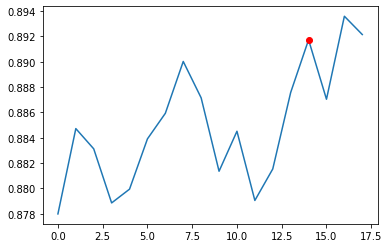

In [44]:
i = 22
prices = [xs[0] for xs in balanced_x_test[i]] + list(balanced_sanity_test[i])
plt.plot(prices)
plt.plot(14, prices[14], 'ro')
print(balanced_y_test[i])
plt.show()

In [17]:
print([xs[0] for xs in balanced_x_train[i]])

[0.48224975792502633, 0.4842579527847454, 0.48818865192899324, 0.4887792932348066, 0.48880589804948493, 0.4936904771346398, 0.49731702340430595, 0.4988349758862323, 0.49714870649409826, 0.4984983060159326, 0.5034508391331589, 0.5095816987714921, 0.5012831956347916, 0.49990994738879874, 0.5016523464509249]


In [18]:
print(balanced_sanity_train[i])

[0.49960871 0.49659646 0.48888856]


[[0.48224976 0.23867363 0.73902684 0.00499002 0.58765319 0.16944717
  0.74093193 0.13678711 0.55499821 0.34444557 0.82343347 0.18028791]
 [0.48425795 0.32572757 0.74744533 0.00634614 0.59327797 0.17303148
  0.74705761 0.15549521 0.57943763 0.34850495 0.83055982 0.16690096]
 [0.48818865 0.28911343 0.73574416 0.00760055 0.59438102 0.16615235
  0.73804116 0.12157757 0.58256436 0.34924458 0.8313688  0.16219738]
 [0.48877929 0.25812244 0.72674326 0.00487198 0.59721376 0.1894346
  0.74588754 0.09928128 0.58301827 0.34839298 0.83877759 0.17153531]
 [0.4888059  0.27267958 0.73394398 0.01058652 0.60016462 0.24471869
  0.76075435 0.14504119 0.57456156 0.35127591 0.84069078 0.13714354]
 [0.49369048 0.27083779 0.73404988 0.00330868 0.60021179 0.1496775
  0.75380274 0.14235205 0.58883858 0.36318046 0.83855935 0.13267951]
 [0.49731702 0.32225261 0.72203103 0.0029483  0.61255639 0.24560208
  0.7391424  0.17575025 0.59788055 0.36736095 0.84540318 0.16513299]
 [0.49883498 0.27369039 0.72192513 0.006221